## Exercise 1 Hello World

1. Write an MPI program displaying the number of processes used for the execution and the rank of each process.
2. Test the programs obtained with different numbers of threads for the parallel program.

**Output Example**
```shell
Hello from the rank 2 process
Hello from the rank 0 process
Hello from the rank 3 process
Hello from the rank 1 process
Parallel execution of hello_world with 4 process
```
*Note that the output order maybe different*

In [92]:
 %%file hello.py
 # write your program here
from mpi4py import MPI
COMM = MPI.COMM_WORLD
SIZE = COMM.Get_size()
RANK = COMM.Get_rank()
print('Hello from the rank {RANK} process'.format(RANK = RANK))
COMM.Barrier()
if RANK == 0:
    print('Parallel execution of hello_world with {SIZE}\n'.format(SIZE = SIZE))

Overwriting hello.py


In [49]:
# enter command for compile and run the program
!mpirun -n 4 python3 hello.py

## Exercise 2 Sharing Data 

A common need is for one process to get data from the user, either by reading from the terminal or command line arguments, and then to distribute this information to all other processors.

Write a program that reads an integer value from the terminal and distributes the value to all of the MPI processes. Each process should print out its rank and the value it received. Values should be read until a negative integer is given as input.

You may want to use these MPI routines in your solution:
`Get_rank` `Bcast` 

**Output Example**
```shell
10
Process 0 got 10
Process 1 got 10
```

In [33]:
 %%file sharing.py
 # write your program here
from mpi4py import MPI
COMM = MPI.COMM_WORLD
RANK = COMM.Get_rank()
SIZE = COMM.Get_size()
while True:
    if RANK == 0:
        sendbuf = int(input())
    else: 
        sendbuf = None    
    recv = COMM.bcast(sendbuf, root = 0)    
    print('Process {RANK} got {data}'.format(RANK = RANK, data = recv))   
    if recv < 0: break

Overwriting sharing.py


In [4]:
# enter command for compile and run the program
!mpirun -n 4 python3 sharing.py

^C


## Exercise 3 Sending in a ring (broadcast by ring)

Write a program that takes data from process zero and sends it to all of the other processes by sending it in a ring. That is, process i should receive the data and send it to process i+1, until the last process is reached.
Assume that the data consists of a single integer. Process zero reads the data from the user.
![](../data/ring.gif)

You may want to use these MPI routines in your solution:
`Send` `Recv` 

In [169]:
%%file ring.py
from mpi4py import MPI
COMM = MPI.COMM_WORLD
RANK = COMM.Get_rank()
SIZE = COMM.Get_size()
tag = 100
if RANK == 0:
    sendbuf = int(input())    
    COMM.send(sendbuf, dest = RANK + 1, tag = tag)
else:
    recvbuf = COMM.recv(source = RANK - 1, tag = tag)
    print('I, process',RANK,',I received',recvbuf,'from the process',RANK-1)
    if RANK != SIZE - 1:
        COMM.send(recvbuf,dest = (RANK + 1)%SIZE, tag = tag)   

Overwriting ring.py


In [170]:
# enter command for compile and run the program
!mpirun -n 4 python3 ring.py

## Exercise 4 Matrix vector product

1. Use the `MatrixVectorMult.py` file to implement the MPI version of matrix vector multiplication.
2. Process 0 compares the result with the `dot` product.
3. Plot the scalability of your implementation. 

**Output Example**
```shell
CPU time of parallel multiplication using 2 processes is  174.923446
The error comparing to the dot product is : 1.4210854715202004e-14
```

In [69]:
 %%file MatrixVectorMult_V0.py
 # write your program here
import time 
import numpy as np
from scipy.sparse import lil_matrix
from numpy.random import rand, seed
from numba import njit
from mpi4py import MPI


''' This program compute parallel csc matrix vector multiplication using mpi '''

COMM = MPI.COMM_WORLD
nbOfproc = COMM.Get_size()
RANK = COMM.Get_rank()

seed(42)

def matrixVectorMult(A, b, x):
    
    row, col = A.shape
    for i in range(row):
        a = A[i]
        for j in range(col):
            x[i] += a[j] * b[j]

    return 0

########################initialize matrix A and vector b ######################
#matrix sizes
SIZE = 1000
Local_size = SIZE // nbOfproc


# counts = block of each proc
proc_block = Local_size * SIZE
counts =  [proc_block for i in range(nbOfproc)]

if RANK == 0:
    A = lil_matrix((SIZE, SIZE))
    A[0, :100] = rand(100)
    A[1, 100:200] = A[0, :100]
    A.setdiag(rand(SIZE))
    A = A.toarray()
    b = rand(SIZE)
else :
    A = None
    b = None



#########Send b to all procs and scatter A (each proc has its own local matrix#####
LocalMatrix = np.empty((Local_size, SIZE), dtype = np.float64)
b = COMM.bcast(b, root = 0)
# Scatter the matrix A
COMM.Scatterv([A, counts, MPI.DOUBLE], LocalMatrix, root = 0)
#####################Compute A*b locally#######################################
LocalX = np.zeros(Local_size)
start = MPI.Wtime()
matrixVectorMult(LocalMatrix, b, LocalX)
stop = MPI.Wtime()
if RANK == 0:
    print("CPU time of parallel multiplication using", nbOfproc,"processes is ", (stop - start)*1000)


##################Gather te results ###########################################
# sendcouns = local size of result
sendcounts = [Local_size for i in range(nbOfproc)] 
if RANK == 0: 
    X = np.empty(SIZE, dtype = np.float64)
else :
    X = None

# Gather the result into X
COMM.Gatherv(LocalX,[X, sendcounts, MPI.DOUBLE], root = 0)

##################Print the results ###########################################

if RANK == 0 :
    X_ = A.dot(b)
    print("The error comparing to the dot product is :", np.max(X_ - X))

Overwriting MatrixVectorMult_V0.py


In [48]:
# enter command for compile and run the program
!mpirun -n 2 python3 MatrixVectorMult_V0.py

## Exercise 5 Calculation of π (Monte Carlo)

1. Use the `PiMonteCarlo.py` file to implement the calculation of PI using Monte Carlo.
2. Process 0 prints the result.
3. Plot the scalability of your implementation. 

In [131]:
 %%file PiMonteCarlo_V0.py
 # write your program here
import random 
import timeit
from mpi4py import MPI


COMM = MPI.COMM_WORLD
nbOfproc = COMM.Get_size()
RANK = COMM.Get_rank()

INTERVAL = 1000 ** 2
#Local interval for each proc
Local_int = INTERVAL //nbOfproc 
random.seed(42)  

def compute_points():
    
    random.seed(42)  
    
    circle_points= 0

    # Total Random numbers generated= possible x 
    # values* possible y values 
    for i in range(Local_int): 
      
        # Randomly generated x and y values from a 
        # uniform distribution 
        # Rannge of x and y values is -1 to 1 
                
        rand_x= random.uniform(-1, 1) 
        rand_y= random.uniform(-1, 1) 
      
        # Distance between (x, y) from the origin 
        origin_dist= rand_x**2 + rand_y**2
      
        # Checking if (x, y) lies inside the circle 
        if origin_dist<= 1: 
            circle_points+= 1
      
        # Estimating value of pi, 
        # pi= 4*(no. of points generated inside the  
        # circle)/ (no. of points generated inside the square) 
    
     
    
    return circle_points


start = timeit.default_timer()
circle_points = compute_points()
end = timeit.default_timer()

#Return the sum of all circle points to the process 0
circle_points = COMM.reduce(circle_points, op = MPI.SUM, root = 0)
if RANK == 0:
    pi = 4* circle_points/ INTERVAL
    print("Circle points number :",circle_points)
    print("Final Estimation of Pi=", pi, "cpu time :",(end-start) * 1000) 


Overwriting PiMonteCarlo_V0.py


Text(0, 0.5, 'CPU time (ms)')

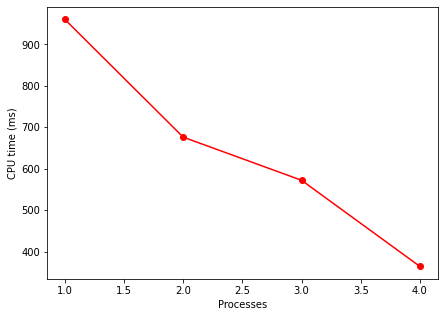

In [2]:
import numpy as np
import matplotlib.pyplot as plt
procs = [1,2,3,4]
time = [960.3, 676.2, 572.15, 364.30]
plt.figure(figsize=(7, 5))
plt.plot(procs, time,'-or')
plt.xlabel('Processes')
plt.ylabel('CPU time (ms)')